# Chapter 2 机器学习概论

## 2.1 机器学习实践五要素

- 数据
- 模型
- 学习准则
- 优化算法
- 评价指标

**从流程角度看**
1. 模型准备
2. 模型训练
3. 模型评价（模型测试）
4. 模型预测（模型推断）

## 2.2 线性回归模型

In [293]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import os
import math

class Op(object):
    def __init__(self):
        pass

    def __call__(self, inputs):
        return self.forward(inputs)
    
    def forward(self, inputs):
        raise NotImplementedError
    
    def backward(self, outputs_grads):
        raise NotImplementedError

In [294]:
def create_toy_data(func, interval, sample_sum, noise = 0.0, add_outlier = False,
                    outlier_ratio = 0.001):
    """
    输入:
        func: 生成样本使用的函数
        interval: x 的取值范围, shape=[2]
        sample_sum: 样本数目
        noise: 噪声均方差（标准差）
        add_outlier: 是否生成异常值
        outlier_ratio: 异常值占比
    输出:
        X: 特征数据, shape=[sample_sum, 1]
        y: 标签数据, shape=[sample_sum, 1]
    """
    X = torch.rand([sample_sum, 1]) * (interval[1] - interval[0]) + interval[0]
    y = func(X)

    # noise
    epsilon = torch.normal(mean=0., std=noise, size=(sample_sum, 1))
    y = y + epsilon
    if add_outlier:
        outlier_num = int(sample_sum * outlier_ratio)
        if outlier_num != 0:
            outlier_idx = torch.randint(low=0, high=sample_sum, size=[outlier_num])
            y[outlier_idx] = y[outlier_idx] * 5
    return X, y

In [295]:
def linear_func(x, w=1.2, b=0.5):
    y = w * x + b
    return y

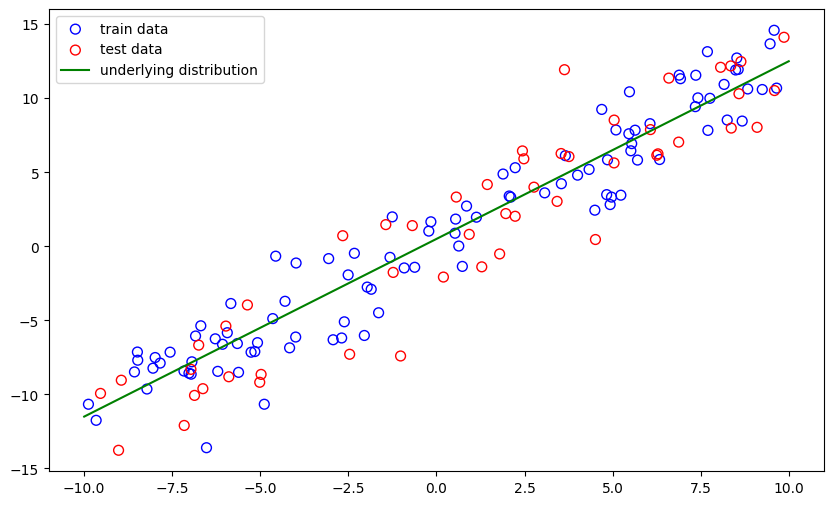

In [296]:
X_train, y_train = create_toy_data(func=linear_func, interval=(-10, 10), sample_sum=100,
                                   noise=2., add_outlier=False)
X_test, y_test = create_toy_data(func=linear_func, interval=(-10, 10), sample_sum=50,
                                 noise=2., add_outlier=False)


X_underlying = torch.linspace(-10, 10, 100)
y_underlying = linear_func(X_underlying)

plt.scatter(X_train, y_train, facecolor="none", edgecolor="b", s=50, label="train data")
plt.scatter(X_test, y_test, facecolor="none", edgecolor="r", s=50, label="test data")
plt.plot(X_underlying, y_underlying, c="g", label=r"underlying distribution")
plt.legend()
plt.show()

In [297]:
torch.seed = 10
class Linear(Op):
    def __init__(self, input_size):
        self.input_size = input_size
        self.params = {}
        self.params['w'] = torch.randn(size=(input_size, 1), dtype=float)
        self.params['b'] = torch.zeros(size=(1, 1), dtype=float)

    def __call__(self, X):
        return self.forward(X)

    def forward(self, X):
        N, D = X.shape
        if D == 0:
            return torch.full(size=(N, 1), fill_value=self.params['b'])
        
        assert D == self.input_size

        y_pred = torch.matmul(X, self.params['w']) + self.params['b']
        return y_pred

input_size = 3
N = 2
X = torch.randn(size=(N, input_size), dtype=float)
model = Linear(input_size)
y_pred = model(X)
print("y_pred:", y_pred)

y_pred: tensor([[-1.1001],
        [ 2.5026]], dtype=torch.float64)


### 损失函数

In [298]:
def mean_squared_error(y_true, y_pred):
    assert y_true.shape[0] == y_pred.shape[0]

    error = torch.mean(torch.square(y_true - y_pred))
    return error

y_true = torch.tensor([[-0.2], [4.9]])
y_pred = torch.tensor([[1.3], [2.5]])
print("error:", mean_squared_error(y_true, y_pred).item())

error: 4.005000114440918


### 优化器

In [299]:
def optimizer_lsm(model, X, y, reg_lambda=0):
    N, D = X.shape
    x_bar_tran = torch.mean(X, dim=0).T
    y_bar = torch.mean(y)

    x_sub = X - x_bar_tran

    if torch.all(x_sub == 0):
        model.params['b'] = y_bar
        model.params['w'] = torch.zeros([D])
        return model
    
    tmp = torch.inverse(torch.matmul(x_sub.T, x_sub) + reg_lambda * torch.eye(D))

    w = torch.matmul(torch.matmul(tmp, x_sub.T), (y - y_bar))
    b = y_bar - torch.matmul(x_bar_tran, w)

    model.params['b'] = b
    model.params['w'] = torch.squeeze(w, dim = -1)

    return model

### 模型训练

In [300]:
input_size = 1
model = Linear(input_size)

model = optimizer_lsm(model, X_train.reshape([-1, 1]), y_train.reshape([-1, 1]))
print(model.params['w'].item(), model.params['b'].item())

y_train_pred = model(X_train.reshape([-1, 1])).squeeze()
train_error = mean_squared_error(y_true=y_train.squeeze(), y_pred=y_train_pred).item()
print(train_error)

1.2079713344573975 0.43675827980041504
4.057916164398193


## 2.3 多项式回归

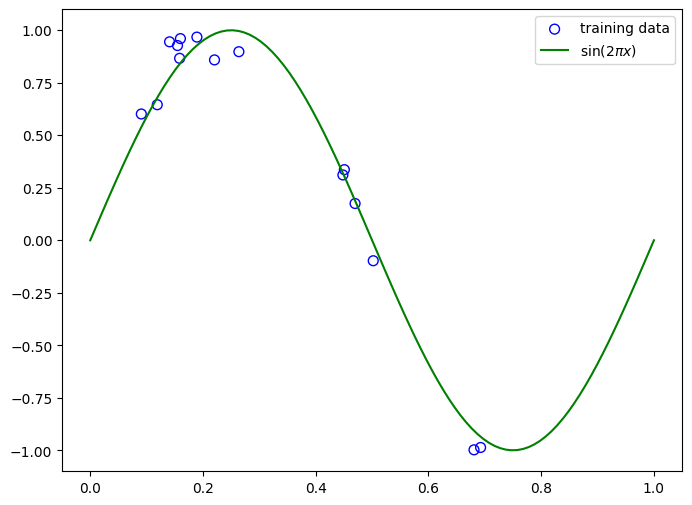

In [301]:
def sin(x):
    y = torch.sin(2 * math.pi * x)
    return y

X_train, y_train = create_toy_data(func=sin, interval=(0, 1), sample_sum=15, noise=0.1)
X_test, y_test = create_toy_data(func=sin, interval=(0, 1), sample_sum=10, noise=0.1)

X_underlying = torch.linspace(0, 1, 100)
y_underlying = sin(X_underlying)

plt.rcParams['figure.figsize'] = (8.0, 6.0)
plt.scatter(X_train, y_train, facecolor="none", edgecolors='b', s=50, label="training data")
plt.plot(X_underlying, y_underlying, c="g", label=r"$\sin(2\pi x)$")
plt.legend()
plt.show()

In [302]:
def polynomial_basis_function(x, degree=2):
    """
    input:
        x: shape=[N, 1]
        degree: 多项式阶数
    """

    if degree == 0:
        return torch.ones_like(x)
    x_tmp = x
    x_result = x_tmp

    for i in range(2, degree + 1):
        x_tmp = torch.multiply(x_tmp, x)
        x_result = torch.concat((x_result, x_tmp), dim = -1)
    return x_result

data = [[2.], [3.], [4.]]
degree = 3
X = torch.tensor(data)
transformed_X = polynomial_basis_function(X, degree)
print(X)
print(transformed_X)


tensor([[2.],
        [3.],
        [4.]])
tensor([[ 2.,  4.,  8.],
        [ 3.,  9., 27.],
        [ 4., 16., 64.]])


torch.Size([100]) torch.Size([100, 1])
{'w': tensor([-2.9657]), 'b': tensor([1.3646])}


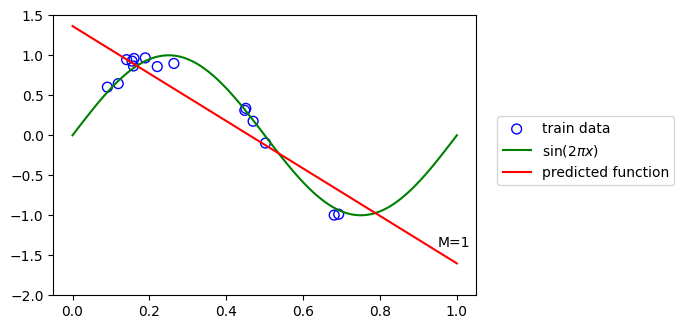

torch.Size([100]) torch.Size([100, 3])
{'w': tensor([ 10.6738, -30.1930,  18.6368]), 'b': tensor([-0.1200])}


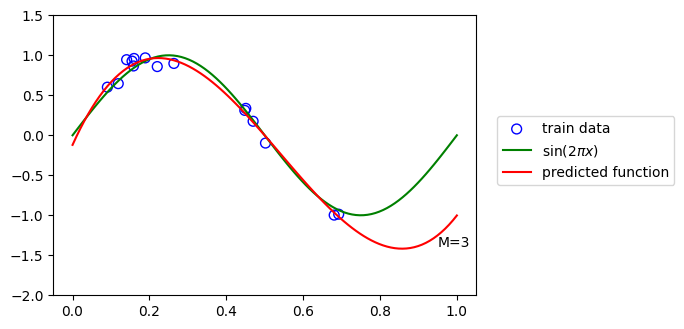

torch.Size([100]) torch.Size([100, 8])
{'w': tensor([  22.2131, -118.1118,  340.7244, -573.6047,  517.6892,  -78.7863,
        -495.0149,  459.4908]), 'b': tensor([-0.9005])}


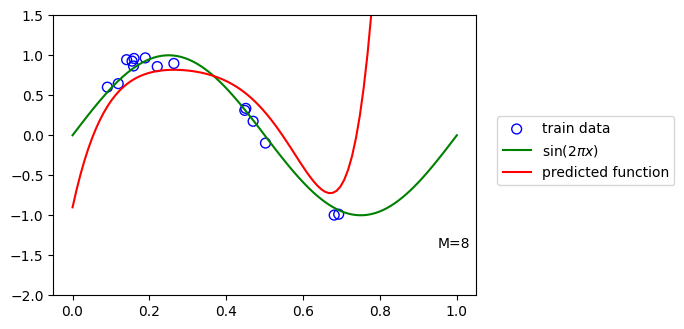

In [303]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)
for i, degree in enumerate([1, 3, 8]):
    model = Linear(degree)
    X_train_transformed = polynomial_basis_function(X_train.reshape([-1, 1]), degree)
    X_underlying_transformed = polynomial_basis_function(X_underlying.reshape([-1, 1]), degree)
    print(X_underlying.shape, X_underlying_transformed.shape)
    model = optimizer_lsm(model, X_train_transformed, y_train.reshape([-1, 1]))

    y_underlying_pred = model(X_underlying_transformed).squeeze()
    print(model.params)
    plt.subplot(2, 2, i + 1)
    plt.scatter(X_train, y_train, facecolor="none", edgecolors="b", s=50, label="train data")
    plt.plot(X_underlying, y_underlying, c="g", label=r"$\sin(2\pi x)$")
    plt.plot(X_underlying, y_underlying_pred, c="r", label="predicted function")
    plt.ylim(-2, 1.5)
    plt.annotate("M={}".format(degree), xy=(0.95, -1.4))
    plt.legend(bbox_to_anchor=(1.05, 0.64), loc=2, borderaxespad=0.)
    plt.show()

    

tensor([ 0.8664,  0.9450,  0.6013,  0.9271,  0.9674, -0.9977,  0.6454,  0.3111,
        -0.0974,  0.8979, -0.9866,  0.3362,  0.9602,  0.1750,  0.8588])
tensor([ 0.9682,  0.9972,  0.9148,  0.9764,  0.8642,  0.4523,  0.9940, -0.6088,
        -0.7698,  0.4351,  0.8173, -0.6184,  0.9648, -0.6830,  0.7058])
{'w': tensor([   18.4402,   -92.0516,   109.3958,   -34.0791,   407.6854, -1133.0038,
          835.4687]), 'b': tensor([-0.0810])}
tensor([[7.2761e-01, 5.2941e-01, 3.8521e-01, 2.8028e-01, 2.0393e-01, 1.4838e-01,
         1.0796e-01],
        [6.8248e-01, 4.6577e-01, 3.1788e-01, 2.1695e-01, 1.4806e-01, 1.0105e-01,
         6.8963e-02],
        [1.7105e-01, 2.9258e-02, 5.0046e-03, 8.5603e-04, 1.4642e-04, 2.5046e-05,
         4.2841e-06],
        [4.6805e-01, 2.1907e-01, 1.0253e-01, 4.7991e-02, 2.2462e-02, 1.0513e-02,
         4.9208e-03],
        [6.2962e-01, 3.9642e-01, 2.4959e-01, 1.5715e-01, 9.8941e-02, 6.2295e-02,
         3.9222e-02],
        [1.5839e-02, 2.5086e-04, 3.9734e-06, 6.29

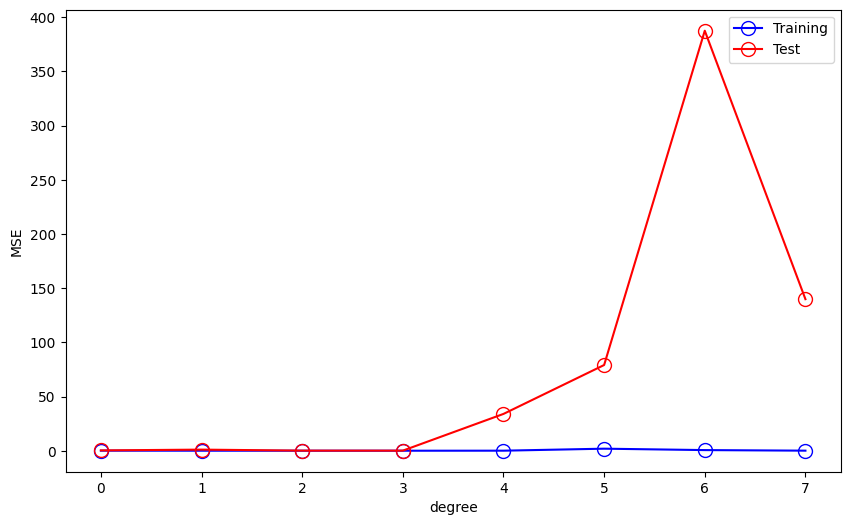

In [304]:
training_errors = []
test_errors = []

for i in range(1, 9):
    X_train_transformed = polynomial_basis_function(X_train.reshape([-1, 1]), degree=i)
    X_test_transformed = polynomial_basis_function(X_test.reshape([-1, 1]), degree=i)
    model = Linear(i)
    model = optimizer_lsm(model, X_train_transformed, y_train.reshape([-1, 1]))
    y_train_pred = model(X_train_transformed).squeeze()
    y_test_pred = model(X_test_transformed).squeeze()

    train_mse = mean_squared_error(y_train.squeeze(), y_train_pred).item()
    training_errors.append(train_mse)
    test_mse = mean_squared_error(y_test.squeeze(), y_test_pred).item()
    test_errors.append(test_mse)

    if i == 7:
        print(y_train.squeeze())
        print(y_train_pred)
        print(model.params)
        print(X_test_transformed)

plt.rcParams['figure.figsize'] = (10.0, 6.0)
plt.plot(training_errors, 'o-', mfc="none", mec="b", ms=10, c="b", label="Training")
plt.plot(test_errors, 'o-', mfc="none", mec="r", ms=10, c="r", label="Test")
plt.legend()
plt.xlabel("degree")
plt.ylabel("MSE")
plt.show()

## 2.4 Runner

In [305]:
class Runner(object):
    def __init__(self, model, optimizer, loss_fn, metric):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.metric = metric
    
    def train(self, train_dataset, dev_dataset=None, **kwargs):
        pass

    def evaluate(self, data_set, **kwargs):
        pass

    def predict(self, x, **kwargs):
        pass

    def save_model(self, save_path):
        pass

    def load_model(self, model_path):
        pass

## 2.5 实践：Boston房价预测

In [306]:
import pandas as pd
data = pd.read_csv("./dataset/boston.csv")
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [307]:
# 查看各字段缺失值情况
data.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
LSTAT      0
MEDV       0
dtype: int64

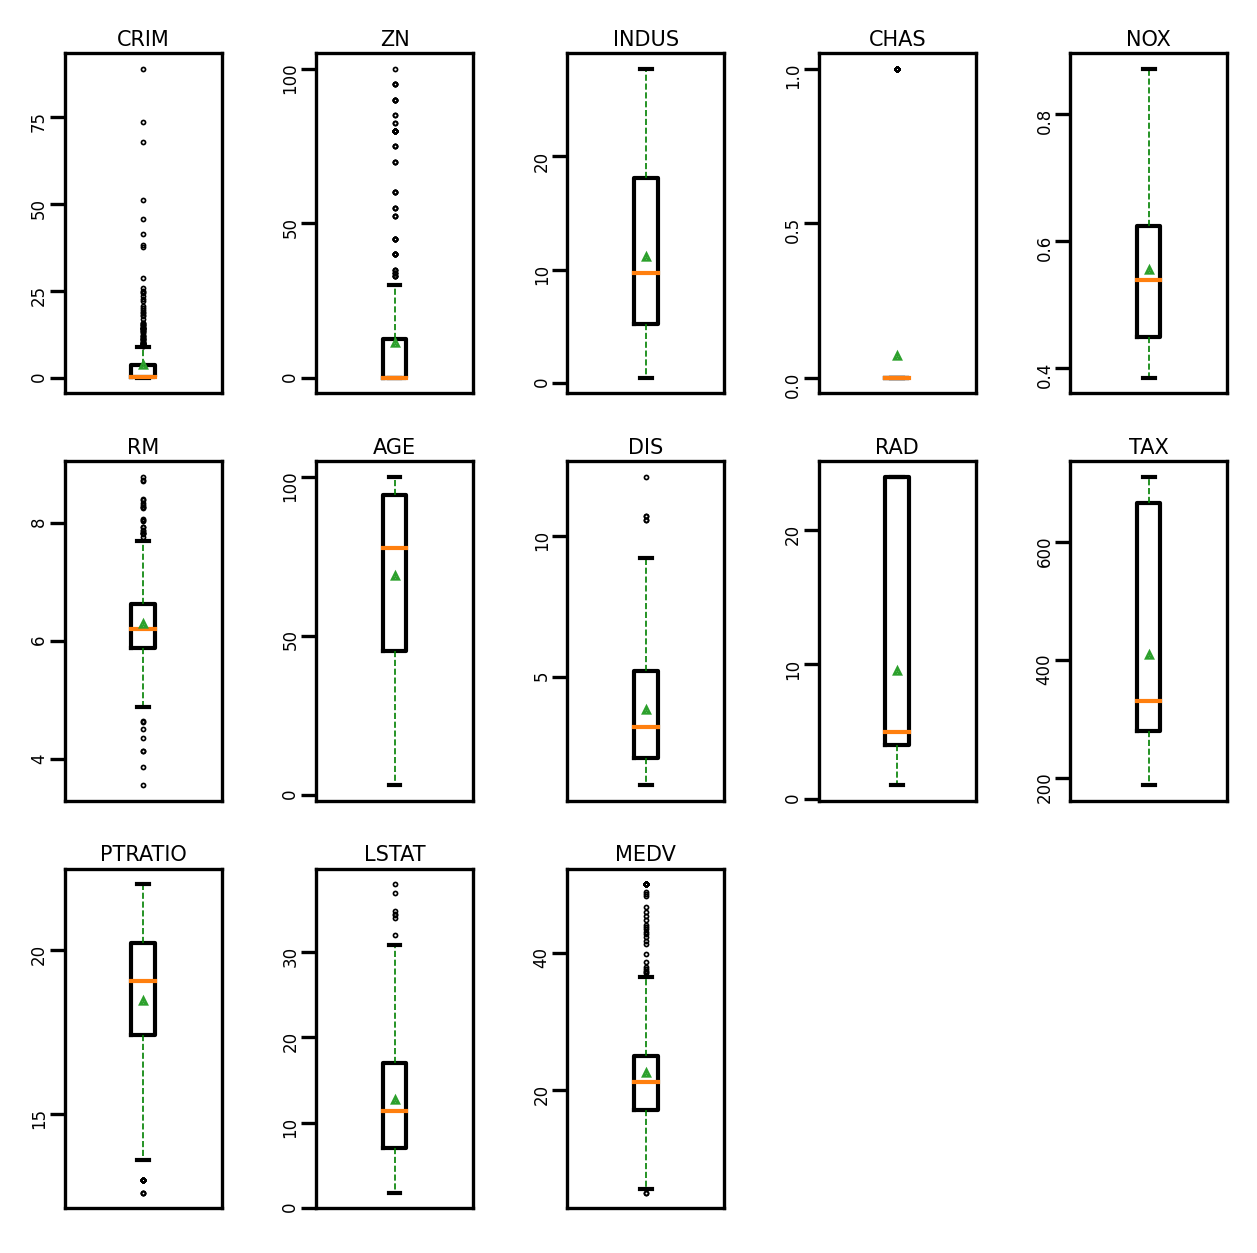

In [308]:
def boxplot(data):
    data_col = list(data.columns)
    plt.figure(figsize=(5, 5), dpi=300)
    plt.subplots_adjust(wspace=0.6)
    for i, col_name in enumerate(data_col):
        plt.subplot(3, 5, i + 1)
        plt.boxplot(data[col_name],
                    showmeans=True,
                    whiskerprops={"color": "g", "linewidth": 0.4, "linestyle": "--"},
                    flierprops={"markersize": 0.4},
                    meanprops={"markersize": 1})
        plt.title(col_name, fontdict={"size": 5}, pad=2)
        plt.yticks(fontsize=4, rotation=90)
        plt.tick_params(pad=0.5)
        plt.xticks([])
    plt.show()

boxplot(data)

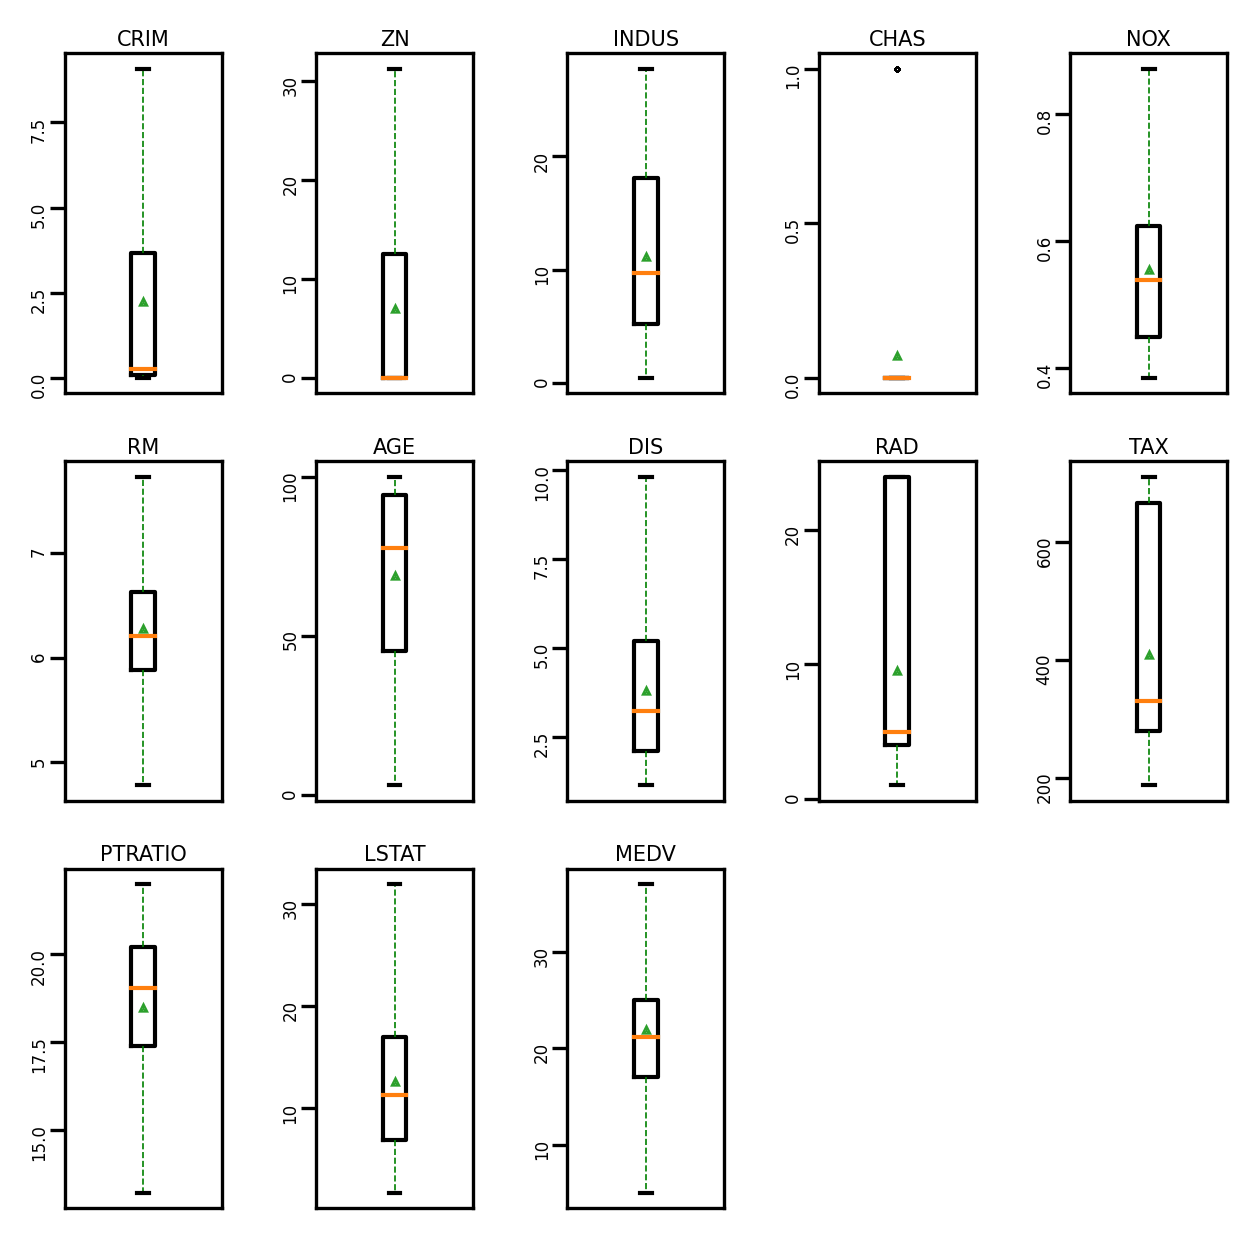

In [309]:
# 识别异常值
num_features = data.select_dtypes(exclude=['object', 'bool']).columns.to_list()

for feature in num_features:
    if feature == 'CHAS':
        continue

    Q1 = data[feature].quantile(q=0.25)
    Q3 = data[feature].quantile(q=0.75)

    top = Q3 + (Q3 - Q1) * 1.5
    bottom = Q1 - (Q3 - Q1) * 1.5
    values = data[feature].values
    values[values > top] = top
    values[values < bottom] = bottom
    # print(data[feature].dtypes)
    data[feature] = values.astype(data[feature].dtypes)
boxplot(data)

In [310]:
# 数据集划分
torch.seed = 10
def train_test_split(X, y, train_percent=0.8):
    n = len(X)
    shuffled_indices = torch.randperm(n) # 返回一个数值在0到n-1、随机排序的一维张量
    train_set_size = int(n * train_percent)
    train_indices = shuffled_indices[:train_set_size]
    test_indices = shuffled_indices[train_set_size:]

    X = X.values
    y = y.values

    X_train = X[train_indices]
    y_train = y[train_indices]

    X_test = X[test_indices]
    y_test = y[test_indices]

    return X_train, y_train, X_test, y_test

X = data.drop(['MEDV'], axis=1)
y = data['MEDV']

X_train, y_train, X_test, y_test = train_test_split(X, y)

In [311]:
# 特征归一化
X_train = torch.tensor(X_train, dtype=float)
y_train = torch.tensor(y_train, dtype=float)
X_test = torch.tensor(X_test, dtype=float)
y_test = torch.tensor(y_test, dtype=float)

# shape=[N, D]
X_train_min, indices = torch.min(X_train, dim=0)
X_train_max, indices = torch.max(X_train, dim=0)
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

train_dataset = (X_train, y_train)
test_dataset = (X_test, y_test)

In [312]:
input_size = X_train.shape[1]
model = Linear(input_size)

class RunnerV1(object):
    def __init__(self, model, optimizer, loss_fn, metric):
        self.model = model
        self.optimizer = optimizer
        # self.loss_fn = loss_fn
        self.metric = metric
    
    def train(self, train_dataset, reg_lambda, model_dir):
        X, y = train_dataset
        self.optimizer(self.model, X, y, reg_lambda)
        self.save_model(model_dir)

    def evaluate(self, dataset):
        X, y = dataset
        y_pred = self.model(X)
        result = self.metric(y_pred, y)
        return result

    def predict(self, X):
        return self.model(X)

    def save_model(self, model_dir):
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        params_saved_path = os.path.join(model_dir, 'params.pt')
        torch.save(model.params, params_saved_path)

    def load_model(self, model_dir):
        params_saved_path = os.path.join(model_dir, 'params.pt')
        self.model.params = torch.load(params_saved_path)


In [313]:
runner = RunnerV1(model, optimizer=optimizer_lsm, loss_fn=None, metric=torch.nn.MSELoss())
runner.train(train_dataset, reg_lambda=0, model_dir='./checkpoint_boston')
columns_list = data.columns.tolist()
weights = runner.model.params['w'].tolist()
b = runner.model.params['b'].item()
for i in range(len(weights)):
    print(columns_list[i], "weights:", weights[i])
print("b:", b)

CRIM weights: -5.706223609516534
ZN weights: 1.2977560543454527
INDUS weights: -0.9536469626130015
CHAS weights: 1.2188059957813417
NOX weights: -6.299280647763561
RM weights: 7.971898546423578
AGE weights: -1.559779379254123
DIS weights: -11.12661841872929
RAD weights: 7.831573567485989
TAX weights: -5.492439559711986
PTRATIO weights: -7.037143208407947
LSTAT weights: -14.03330310417423
b: 34.374516935249474


In [314]:
saved_dir = os.path.join('./checkpoint_boston')
runner.load_model(saved_dir)
mse = runner.evaluate(test_dataset)
print('MSE:', mse.item())

MSE: 11.72322379190529


In [315]:
pred = runner.predict(X_test[:1])
print("ground_truth:", y_test[:1].item())
print("prediction:", pred.item())

ground_truth: 19.4
prediction: 19.669077452048928
